# Проект: классификация клиентов банка

In [633]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from sklearn.preprocessing  import LabelEncoder
from sklearn.preprocessing  import OneHotEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
import optuna
from sklearn.model_selection import cross_val_score


pd.set_option('display.max_columns', 60)

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

In [634]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [635]:
# Исследуем данные на предмет пропусков

df.info()
df[df['balance'].isna() == True].groupby('deposit')['deposit'].count()

# В столбце balance есть 25 пропущенных значений, 
# при этом 5 из этих клиентов открыли депозит, остальные - нет.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


deposit
no     20
yes     5
Name: deposit, dtype: int64

In [636]:
# Проверим данные на предмет неявных пропусков, посмотрев на уникальные значения категориальных признаков

object_features = list()
numeric_features = list()

for column in df.columns:
    if df[column].dtype == 'object':
        object_features.append(column)
    else:
        numeric_features.append(column)

for column in object_features:
    display(df[column].value_counts())
    
# Пропущенные данные в неявном виде так же представлены в столбцах job(70), eduation(497), contact(2346), poutcome(8326)

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

married     6351
single      3518
divorced    1293
Name: marital, dtype: int64

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

no     10994
yes      168
Name: default, dtype: int64

0  $            774
 1,00 $          39
 3,00 $          34
 2,00 $          34
 4,00 $          29
               ... 
 1 641,00 $       1
 5 517,00 $       1
 8 332,00 $       1
 4 859,00 $       1
-134,00 $         1
Name: balance, Length: 3802, dtype: int64

no     5881
yes    5281
Name: housing, dtype: int64

no     9702
yes    1460
Name: loan, dtype: int64

cellular     8042
unknown      2346
telephone     774
Name: contact, dtype: int64

may    2824
aug    1519
jul    1514
jun    1222
nov     943
apr     923
feb     776
oct     392
jan     344
sep     319
mar     276
dec     110
Name: month, dtype: int64

unknown    8326
failure    1228
success    1071
other       537
Name: poutcome, dtype: int64

no     5873
yes    5289
Name: deposit, dtype: int64

In [637]:
# Среди категориальных признаков присутствует столбец balane, который по сути является числовым. 
# Выполним необходимые преобразования, чтобы перевести признак в формат float

df['balance'] = df['balance'].apply(lambda x: float(str(x).replace('$', '').replace(',', '.').replace(' ', '')))
df['balance'].dtype

dtype('float64')

In [638]:
# Теперь мы можем обработать пропуски в признаки balance , заменив их на медианные значения по данному признаку

df['balance'] = df['balance'].fillna(df['balance'].median())

In [639]:
# Обработаем пропуски в категориальных признаках: job и education, заменив их на модальные значения

job_median = df['job'].describe().top
df['job'] = df['job'].apply(lambda x: job_median if x == 'unknown' else x)

education_median = df['education'].describe().top
df['education'] = df['education'].apply(lambda x: education_median if x == 'unknown' else x)

-2241.0 4063.0
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


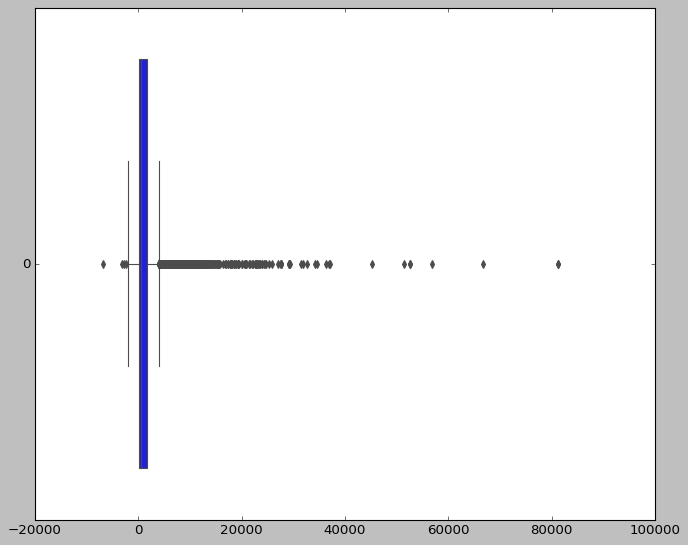

In [640]:
# Найдем выбросы в признаке balance по методу Тьюкки

sns.boxplot(df['balance'], orient='horizontal')

def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    print(lower_bound, upper_bound)
    return outliers, cleaned

outliers, cleaned = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

In [641]:
# После преобразования признака баланса переопределим переменные, в которых хранятся данные о числовых и категориальных признаках
numeric_features = []
object_features = []


for column in df.columns:
    if df[column].dtype == 'object':
        object_features.append(column)
    else:
        numeric_features.append(column)
        
display(object_features, numeric_features)

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'deposit']

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

## Часть 2:  Разведывательный анализ

Text(0.5, 1.0, 'presence / absence of a deposit')

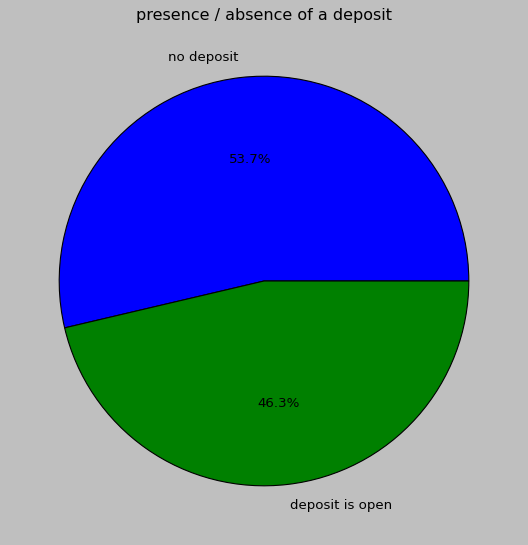

In [642]:
# Изучим соотношение классов в целевом признаке на предмет сбалансированности

cleaned['deposit'].value_counts()
labels = ['no deposit', 'deposit is open']
sizes = [5424, 4681]

plt.pie(sizes, labels = labels, autopct='%.1f%%')
plt.title('presence / absence of a deposit')

In [643]:
# Посмотрим на описательные статистики для количественных переменных

for feature in numeric_features:
    display(cleaned[feature].describe())

count    10105.000000
mean        40.895497
std         11.734931
min         18.000000
25%         32.000000
50%         38.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

count    10105.000000
mean       807.653538
std        994.151966
min      -2049.000000
25%         95.000000
50%        445.000000
75%       1227.000000
max       4063.000000
Name: balance, dtype: float64

count    10105.000000
mean        15.590302
std          8.441510
min          1.000000
25%          8.000000
50%         15.000000
75%         22.000000
max         31.000000
Name: day, dtype: float64

count    10105.000000
mean       368.742603
std        346.651524
min          2.000000
25%        137.000000
50%        252.000000
75%        490.000000
max       3881.000000
Name: duration, dtype: float64

count    10105.000000
mean         2.517170
std          2.707159
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         43.000000
Name: campaign, dtype: float64

count    10105.000000
mean        51.319644
std        109.644179
min         -1.000000
25%         -1.000000
50%         -1.000000
75%          2.000000
max        854.000000
Name: pdays, dtype: float64

count    10105.000000
mean         0.816230
std          2.243795
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         58.000000
Name: previous, dtype: float64

Возраст 219 клиентов более 70 лет
Возраст 5 клиентов более 90 лет
У 686 клиентов отрицательный баланс
С 8 клиентами контакт в рамках текущей кампании поддерживался более 30 раз
Контакт с 6 клиентами не поддерживался более двух лет
С 96 клиентами контактировали более 10 раз до момента текущей кампании


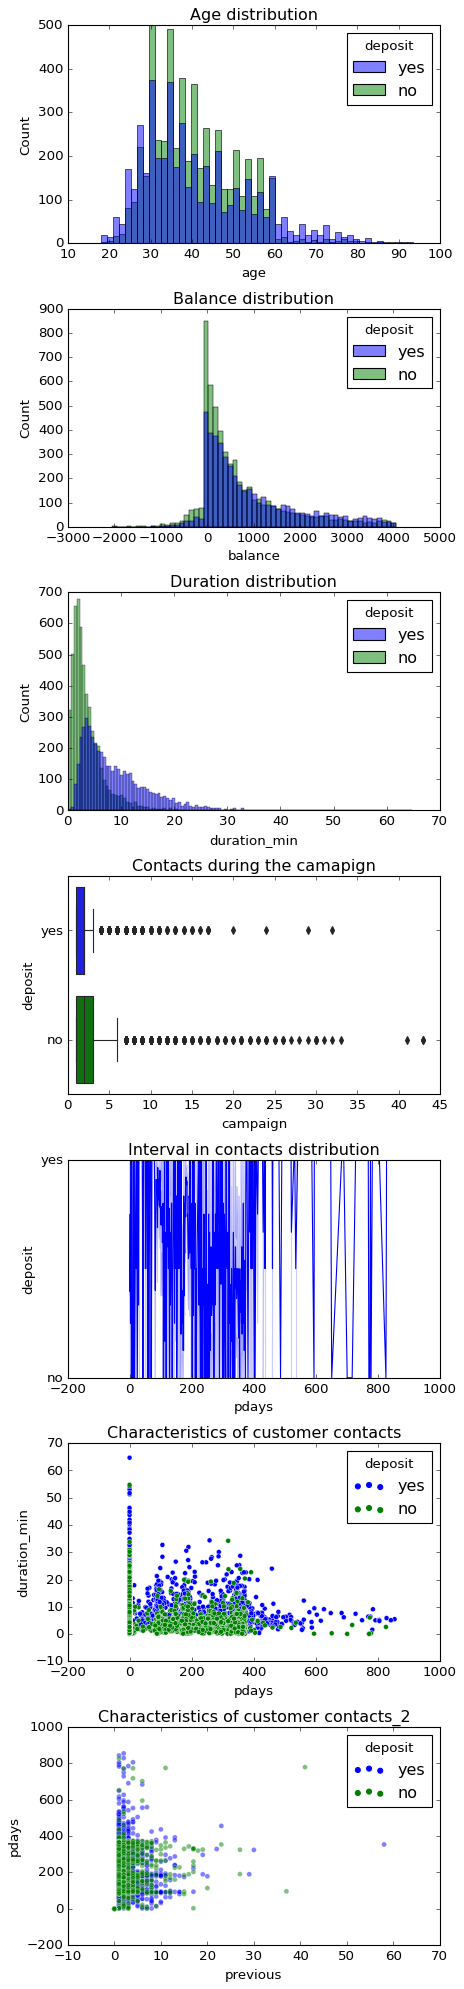

In [644]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(6, 30))
plt.style.use('classic')
fig.patch.set_facecolor('xkcd:white')
plt.subplots_adjust(hspace=0.3)
    
# Таким образом, можно заметить, что:

# 1. Возраст ('age')
print('Возраст {} клиентов более 70 лет'.format(cleaned[cleaned['age'] > 70].shape[0]))
print('Возраст {} клиентов более 90 лет'.format(cleaned[cleaned['age'] > 90].shape[0]))

ax = axes[0]
ax = sns.histplot(cleaned, x = 'age', hue = 'deposit', ax = ax)
ax.set_title('Age distribution')

# Возраст клиентов банка варьируется от 18 до 95 лет.
# Клиентов старше 70 лет всего 219, а старше 90 лет - всего 5.
# Посмотрев на зависимость целевой переменной от возраста, можно отметить, что в возрастной группе клиентов до 30 лет, 
# кличество открывших депозит - больше, чем клиентов без депозита. Такая же зависимость наблюдается в группе клиентов после 60 лет.
# Возрастному коридору клиентов от 30 до 40 лет соответствует наибольшее количество открытых депозитов, 
# но в то же время процент клиентов без депозита в этой возрастной группе превышаетпроцент клиентов, у которых есть депозит.
 
 
 
# 2. Баланс ('balance')

print('У {} клиентов отрицательный баланс'.format(df[df['balance'] < 0].shape[0]))

# У 686 клиентов отрицательный баланс.

ax = axes[1]
ax = sns.histplot(cleaned, x = 'balance', hue = 'deposit', ax = ax)
ax.set_title('Balance distribution')

# Оценивая влияние фактора баланса на открытие депозита можно отметить, что у клиентов с отрицательным баланом депозита чаще нет.
# У большинства клиентов с открытым дипозитом, баланс на счете варьируется в пределах от 0 до 1 200.
# В группе клиентов, баланс которых превышает 1 300, чаще встречаются клиенты, у которых депозит открыт.



# 3. Продолжительность контакта с клиентом

cleaned['duration_min'] = cleaned['duration']/60
ax = axes[2]
sns.histplot(cleaned, x = 'duration_min', hue = 'deposit', ax = ax)
ax.set_title('Duration distribution')

# Говоря о распределении признака, можно отметить, что продолжительность контактов с клиентами варьируется от 2 секунд до 65 минут;
# Клиенты, у которых открыт депозит, имеют больее продолжительный контакт (от 2 до 30 минут) с сотрудником банка.
# Более 30 минут общаются клиенты как с депозитом, так и без него, однако продолжительный контакт случается редко.
# Вероятно, на протяжении долгого времени клиент скорее решает свою проблему, чем уточняет условия пользования продуктом.

# 4. Количество конатктов с клиентом в рамках текущей кампапии (признак campaign)

ax = axes[3]
ax = sns. boxplot(cleaned, x = 'campaign', y = 'deposit', ax = ax)
ax.set_title('Contacts during the camapign')

print('С {} клиентами контакт в рамках текущей кампании поддерживался более 30 раз'.format(df[df['campaign'] > 30].shape[0]))

# На графике видно, что контактов с клиентами, у которых нет депозита - больше, что очень логично: требуется приложить больше усилий 
# для того, чтобы продать клиенту новую услугу, чем на поддержание контакта с клиентом или консультационной поддержки. 
# В среднем с клиентами в рамках текущей кампании контакт поддерживается 2-3 раза. 
# Есть 8 наблюдений с количеством контаков более 30 раз. 


# 5. Количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании

print('Контакт с {} клиентами не поддерживался более двух лет'.format(df[df['pdays'] > 800].shape[0]))
ax = axes[4]
ax = sns.lineplot(cleaned, x = 'pdays', y = 'deposit', orient = 'x', ax = ax)
ax.set_title('Interval in contacts distribution')

# Среди клиентов, контакт с которыми поддерживается в течении 200 дней, клиентов с открытым депозитом больше. 
# Количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей 
# кампании для большинства клиентов = 2.
# Однако, есть 6 клиентов, контакт с которыми не поддерживался более 2 ле.

ax = axes[5]
ax = sns.scatterplot(data = cleaned, x = 'pdays', y = 'duration_min', hue = 'deposit', ax = ax)
ax.set_title('Сharacteristics of customer contacts')


# Посмотрев на распределение признаков возраста, количества дней с последнего контакта, а так же нашего целевого признака - 
# наличия депозита, можно отметить, что для людей старшего возраста (60 лет+) почти не характере длительный период без контакта. 
# Это может быть обусловлено тем, что у людей этой возрастной группы склонность к более продолжительному разговору выше,
# а времени для контакта больше.



# 6. Количество контакт до текущей кампании

print('С {} клиентами контактировали более 10 раз до момента текущей кампании'.format(df[df['previous'] > 10].shape[0]))
ax = axes[6]
ax = sns.scatterplot(data = cleaned, x = 'previous', y  = 'pdays', hue = 'deposit', alpha = 0.5, ax = ax)
ax.set_title('Сharacteristics of customer contacts_2')


# Большее количество наблюдений показывает, что до момента текущей кампании с клиентом было до 10 контактов.
# Так же можно отметить, что клиенты, у которых открыт депозит, чаще контьактируют с сотрудниками банка.  
# С 96 клиентами контактировали более 10 раз до момента текущей кампании, в то время как среднее количество контактов - 2.


# Признак "day" обозначается как числовой, но требует перевода в признак времени.

plt.show()

In [645]:
#рассчитаем некоторые описательные статистики для категориальных переменных

for feature in object_features:
    print('Количество уникальных значений признака {} = {}; Самое часто встречающееся значение - "{}". Все уникальные значения признака: {}.'.format(feature, cleaned[feature].nunique(), cleaned[feature].mode(), cleaned[feature].unique()))

Количество уникальных значений признака job = 11; Самое часто встречающееся значение - "0    management
Name: job, dtype: object". Все уникальные значения признака: ['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'self-employed' 'student'].
Количество уникальных значений признака marital = 3; Самое часто встречающееся значение - "0    married
Name: marital, dtype: object". Все уникальные значения признака: ['married' 'single' 'divorced'].
Количество уникальных значений признака education = 3; Самое часто встречающееся значение - "0    secondary
Name: education, dtype: object". Все уникальные значения признака: ['secondary' 'tertiary' 'primary'].
Количество уникальных значений признака default = 2; Самое часто встречающееся значение - "0    no
Name: default, dtype: object". Все уникальные значения признака: ['no' 'yes'].
Количество уникальных значений признака housing = 2; Самое часто встречающееся значение - "0    no
Name:

Text(0.5, 1.0, 'Contact characteristics')

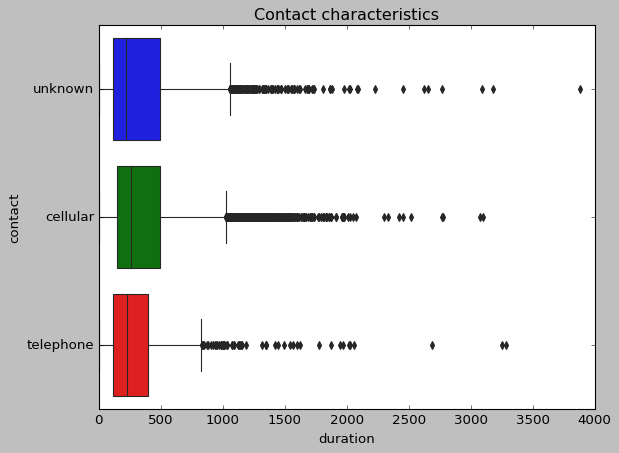

In [646]:
# Построим график распределений длительности контактов и их типов
 
sns.boxplot(cleaned, x = 'duration', y = 'contact').set_title('Contact characteristics')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'admin.'),
  Text(1, 0, 'technician'),
  Text(2, 0, 'services'),
  Text(3, 0, 'management'),
  Text(4, 0, 'retired'),
  Text(5, 0, 'blue-collar'),
  Text(6, 0, 'unemployed'),
  Text(7, 0, 'entrepreneur'),
  Text(8, 0, 'housemaid'),
  Text(9, 0, 'self-employed'),
  Text(10, 0, 'student')])

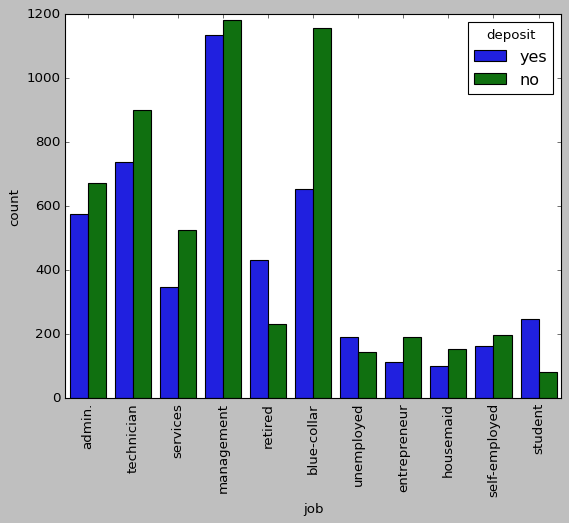

In [647]:
# Посмотрим на распределение признака 'job' 

sns.countplot(cleaned, x = 'job', hue = 'deposit')
plt.xticks(rotation=90)

(array([0, 1, 2]),
 [Text(0, 0, 'married'), Text(1, 0, 'single'), Text(2, 0, 'divorced')])

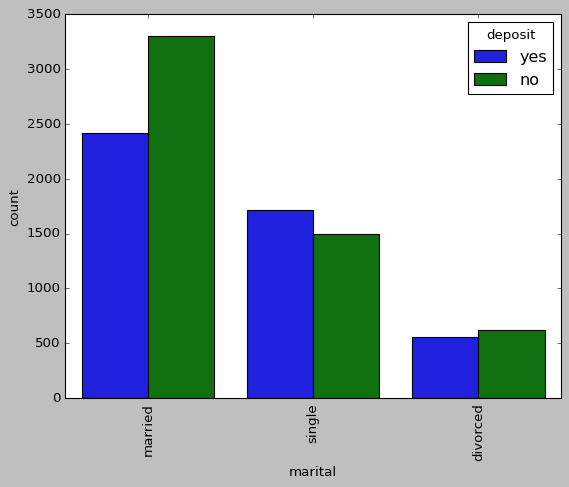

In [648]:
# Посмотрим на распределение признака 'marital' 

sns.countplot(cleaned, x = 'marital', hue = 'deposit')
plt.xticks(rotation=90)

(array([0, 1, 2]),
 [Text(0, 0, 'secondary'), Text(1, 0, 'tertiary'), Text(2, 0, 'primary')])

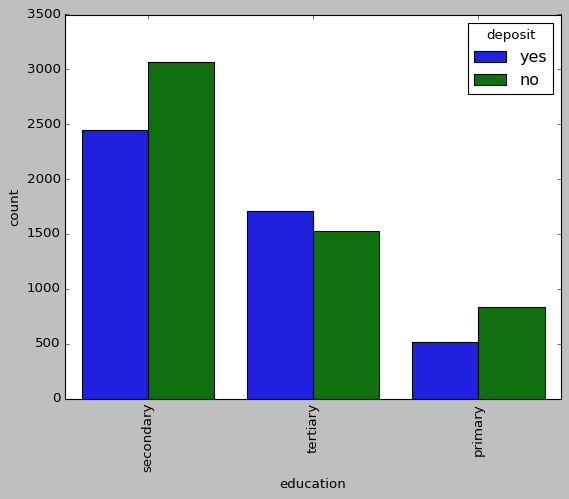

In [649]:
# Посмотрим на распределение признака 'education' 

sns.countplot(cleaned, x = 'education', hue = 'deposit')
plt.xticks(rotation=90)

(array([0, 1]), [Text(0, 0, 'no'), Text(1, 0, 'yes')])

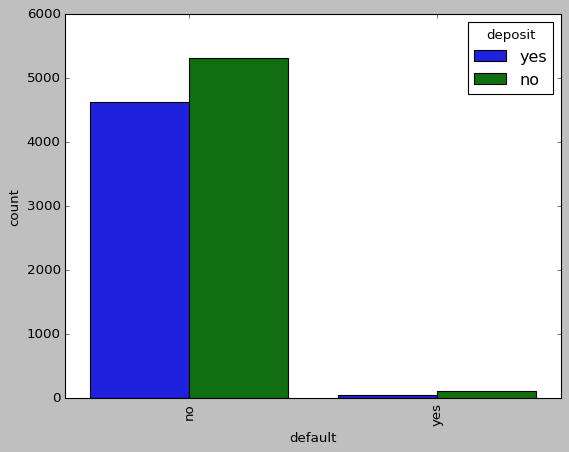

In [650]:
# Посмотрим на распределение признака 'default' 

sns.countplot(cleaned, x = 'default', hue = 'deposit')
plt.xticks(rotation=90)

(array([0, 1]), [Text(0, 0, 'no'), Text(1, 0, 'yes')])

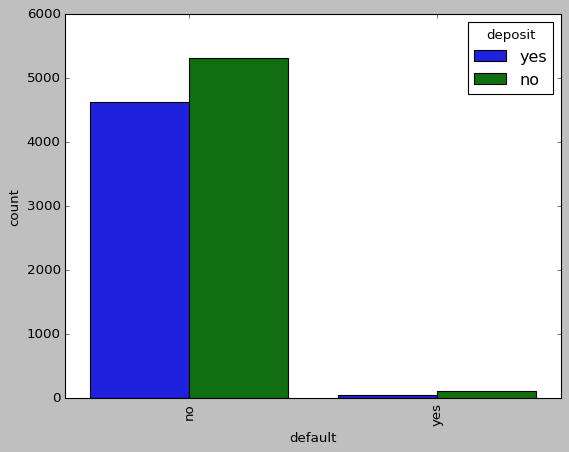

In [651]:
# Посмотрим на распределение признака 'default' 

sns.countplot(cleaned, x = 'default', hue = 'deposit')
plt.xticks(rotation=90)

(array([-3000., -2000., -1000.,     0.,  1000.,  2000.,  3000.,  4000.,
         5000.]),
 [Text(-3000.0, 0, '−3000'),
  Text(-2000.0, 0, '−2000'),
  Text(-1000.0, 0, '−1000'),
  Text(0.0, 0, '0'),
  Text(1000.0, 0, '1000'),
  Text(2000.0, 0, '2000'),
  Text(3000.0, 0, '3000'),
  Text(4000.0, 0, '4000'),
  Text(5000.0, 0, '5000')])

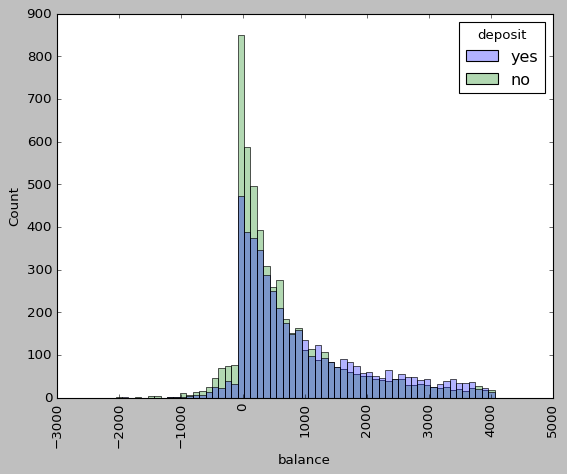

In [652]:
# Посмотрим на распределение признака 'balance' 

sns.histplot(cleaned, x = 'balance', hue = 'deposit', alpha = 0.3)
plt.xticks(rotation=90)

(array([0, 1]), [Text(0, 0, 'yes'), Text(1, 0, 'no')])

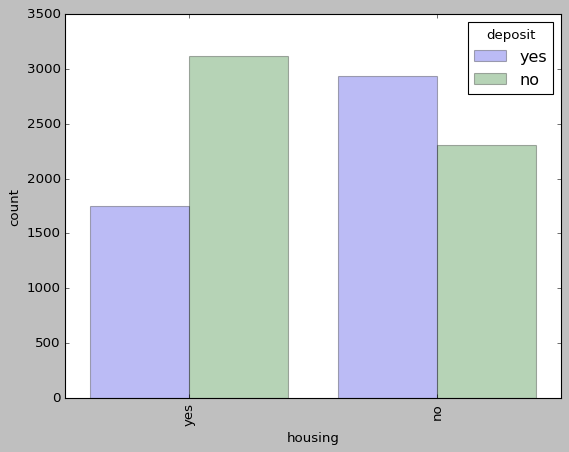

In [653]:
# Посмотрим на рапределение признака 'housing' который может рассказать о том, есть ли у клиента кредит на дом 

sns.countplot(cleaned, x = 'housing', hue = 'deposit', alpha = 0.3)
plt.xticks(rotation=90)


(array([0, 1]), [Text(0, 0, 'no'), Text(1, 0, 'yes')])

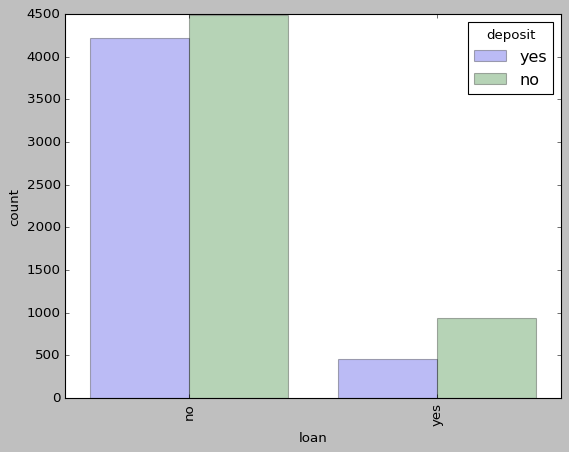

In [654]:
# Посмотрим на рапределение признака 'loan', который может рассказать о том, есть ли у клиента кредит на личные нужды

sns.countplot(cleaned, x = 'loan', hue = 'deposit', alpha = 0.3)
plt.xticks(rotation=90)

poutcome  deposit
unknown   no         4562
          yes        3008
success   yes         861
failure   no          562
          yes         547
other     yes         265
          no          216
success   no           84
Name: deposit, dtype: int64

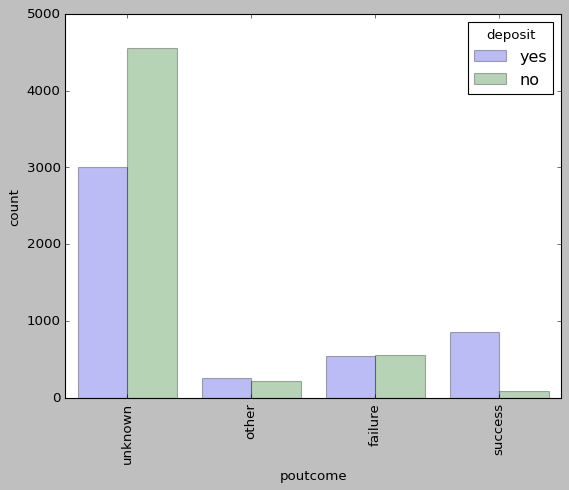

In [655]:
# Исследуем как результат прошлой маркетинговой кампании (признак poutcome) влияет на результат в текущей 

sns.countplot(cleaned, x = 'poutcome', hue = 'deposit', alpha = 0.3)
plt.xticks(rotation=90)

campaigns_results = cleaned.groupby(['poutcome', 'deposit'])['deposit'].count().sort_values(ascending = False)
campaigns_results 

#  Что интересного можно заметить из статистики и графиков:

У признака 'contact' есть три значения: unknown, cellular, telephone. 
Разница между значенияи ccellular и telephone не очевидна, хотя это знание пригодилось бы для выдвижения предлположений о том, почему длительность контактов типа telephone меньше контактов другого типа.
А длительность контактов типа cellular похожа на длительность контактов другого типа. 
Вероятно, тип cellular предполагет самостоятельный звонок клиента в банк (так как продолжительность контактов больше, чем telephone. Клиенту, которые сами заинтересованы в разговоре, вероятно дольше общаются с сотрудниками банка. Следуя этому предположению, клиентам, которым звонили сотрудники банка (контакт типа telephone) менее заинтересованы в разговоре, следовательно продолжительность сокращается).

Лишь для трех категорий признака "job" характерно превышение количества клиентов, открывших вклад: retired, unemlpoyed, student. 
Вероятно, для категории retired характерно накопление средств к моменту ухода на пенсию, не такие активные траты.
Возможно клиенты категории "unemployed" работают не официально или имеют достаточно наколений, чтобы открыт депозит и временно не работать. Однако, это скорее притянутые предположения, чем характеристика партрета клиентов, которые открывают депозит.
Для категории "student" так же часто характерно накопление д/с на депозитах, перечисление стипендии на депозит.
Топ-3 категории, которым характерно наибольшее количество открытх вкладов: technician, managmant, blue-collar. 

Касаемо семейного положения (признака marital), наибольшее количество открытых вкладов приходится на груму женатых/замужних клиентов (почти 2.5 тысячи клиентов). На свободных клиетов приходится около 1700 открытых депозитов, на разведенных - около 500.
Однако, сравнивая соотношение внутри этих групп, надо отметить, что разведенные и семейные клиенты чаще отказываются от открытия депозита, в том время как свободные клиенты намного чаще открывают депозит.

Из признакаа степени образования можно выделить факто том, что выпускники начальной и средних школ чаще не открывают депозиты, в то время как клиенты с высшим образованием чаще имеют депозит. 
Наибольшее количество открытых вкладов приходится на группу клиентов, которые законгчили среднюю школу.

Из признака default мы можем узнать есть ли у клиента просроченный кредит.
Процент клиентов с просрочками небольшой, но даже в этой группе есть клиенты, у которых есть депозит.
Почему случается так, что у человека сос свободными средствами появляется просрочка по кредиту?
Возможно,  причина может быть банальна: забывчивость. Тогда можно подумать об автоматической системе напоминаний. Возможно, дата платежа по кредиту неудобна для клиента: например, зарплата приходит на карту 5 числа, а платеж выпадает на каждое первое число. Во многих банках есть возможность выбрать и поменять дату платежа.
Если этот критерий влияет на оценку клиента банком и важен при предложении ему дополнительных услуг, стоит более конкретно разобрать возможные причины просрочек и способы решения этой проблемы.


Для признака housing наблюдается следующая тенденция: у клиентов, имеющих кредит на дом, намного реже встречается открытый депозит, чем у клиентов без такого вида займа.

Для признака loan зависимость выражена еще ярче: у клиентов, имеющих кредит на личные нужды, количество открытх депозитов примерно в 8 разх меньше чем у клиентов, не имеющих его.

Анализируя взаимосвязь исхода предыдущей и текущей кампаний, можно отметить, что наибольшее количество клиентов, которые согласились на предложение текущей кампании (открыть депозит), имели неизвестный исход в прошлой кампании. Однако, наибольшее количество отказавшихся так же имеют статус "неизвестно" для результатов прошлой кампании. 
Для клиентов, которые согласились на предложения прошлой кампании, в текущей кампании колтчество клиентов, принявших предложение более чем в 10,5 раз больше отказавшихся. 
Резюмируя, отметит, что для большинства клиентов результаты проведения прошлой кампании - неизвестны. Так же прослеживается прямая взаимосвзь между прошлой и текущей кампаниями: положительный исход предыдущей кампании стимулирует на согласие текущим предложениям.

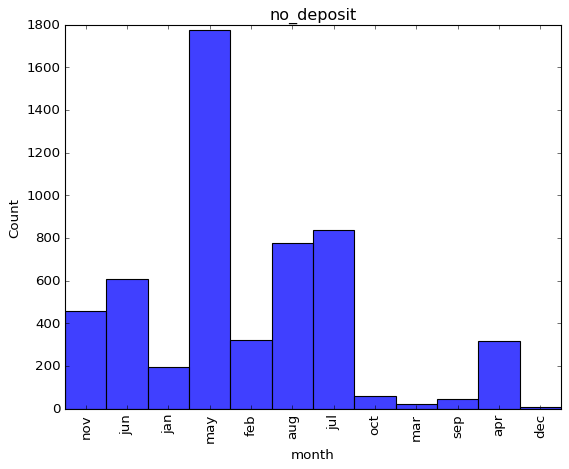

In [656]:
# посмотрим на распределение отказов по месяцам

fig = plt.figure()
plt.style.use('classic')
fig.patch.set_facecolor('xkcd:white')

sns.histplot(cleaned[cleaned['deposit'] == 'no'], x = 'month').set_title('no_deposit')
plt.xticks(rotation=90)

plt.show()

# Из графика можно сделать вывод о том, что Май - не лучший месяц для предложений о вкладах.

<AxesSubplot: xlabel='age', ylabel='deposit'>

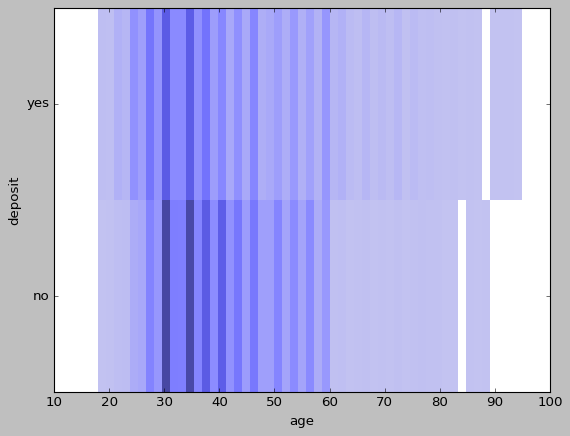

In [657]:
# Посмотрим как возраст влияет на нашу целевую переменную 

sns.histplot(cleaned, x = cleaned['age'], y = cleaned['deposit'])

# Cудя по графику, люди до 30 лет чаще открывают вклад, чем отказываются, а с 30 до 60 лет чаще отказываются. Затем тенденция снова меняется, то есть клиенты в возрасте 60+ чаще открывают вклад, чем отказываются.

marital   deposit
divorced  no          624
          yes         553
married   no         3303
          yes        2412
single    no         1497
          yes        1716
Name: deposit, dtype: int64

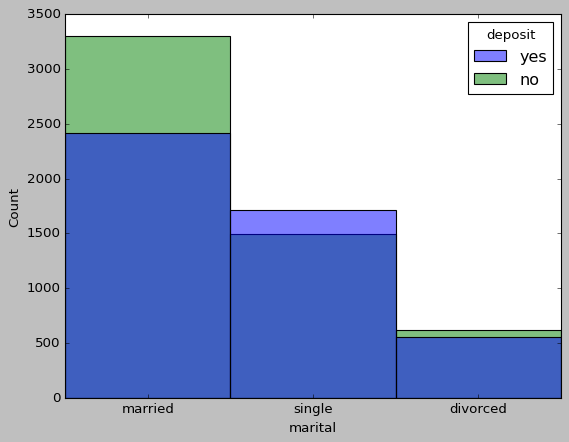

In [658]:
# построим визуализацию для открывших и неоткрывших депозит в зависимости от семейного статуса

sns.histplot(cleaned, x = cleaned['marital'], hue = cleaned['deposit'])

cleaned.groupby(['marital', 'deposit'])['deposit'].count()

# Сравнивая соотношения в разных классах, только для категории клиентов 'single' процент клиентов открывших вклад больше 
# чем клиентов, которые не открыли вклад. 
# Группе клиентов, находящихся в разводе, соответствует наименьшее количество открытых депозитов.
# Группе семейных клиентов, напротив, соответствует наибольшее количество открытых депозитов.

education  deposit
primary    no          832
           yes         517
secondary  no         3066
           yes        2451
tertiary   no         1526
           yes        1713
Name: deposit, dtype: int64

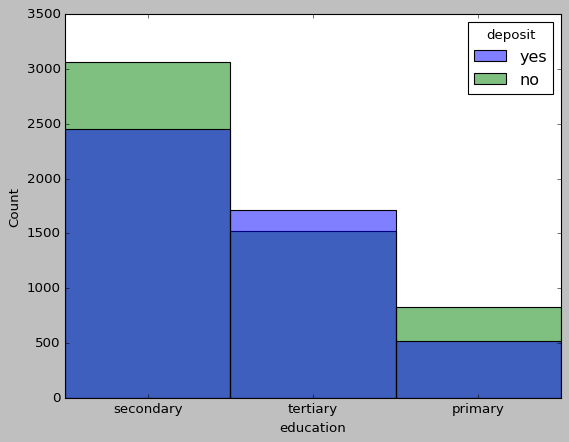

In [659]:
# построим визуализацию для открывших и неоткрывших депозит в зависимости от образования

sns.histplot(cleaned, x = cleaned['education'], hue = cleaned['deposit'])

cleaned.groupby(['education', 'deposit'])['deposit'].count()

# Наибольше и наименьшее количество открытых депозитов приходится на категории клиентов со средним и начальным образованием соответственно. 
# Для клиентов с высшим образованием характерно чуть чаще открывать депозит, чем отказываться от его открытия.


Text(0.5, 1.0, "client's without deposit features")

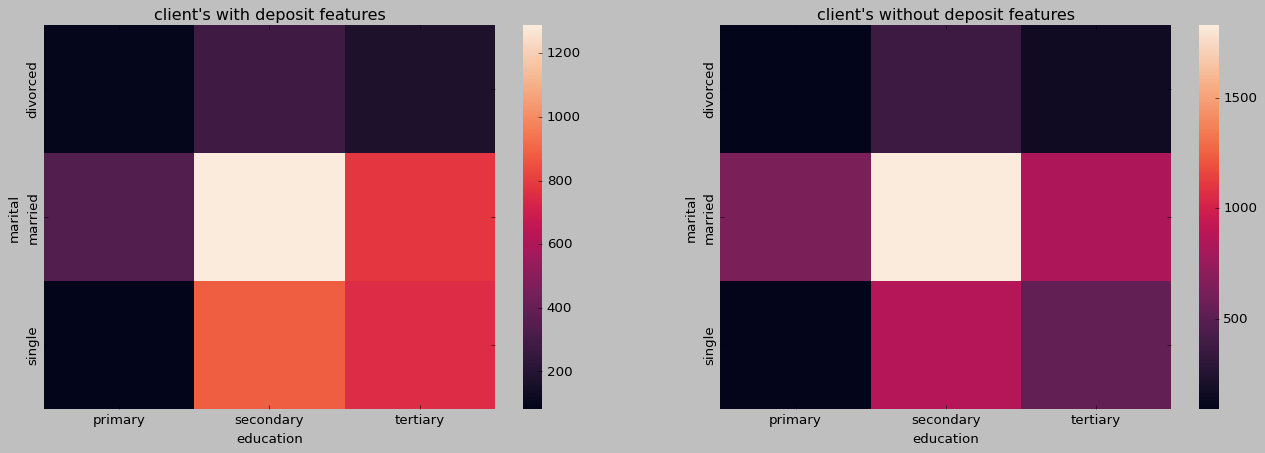

In [660]:
# Ранее мы посмотрели взаимосвязь целевого признака и каждой категории отдельно. 
# Попробуем посмотреть на пересечения категорий и выявить более сложные взаимосвязи, что объединяет людей, открывших вклад.
# Разделим наши данные на две части: клиенты, открывшие депозит и те, кто этого не сделал.
 
with_deposit = cleaned[cleaned['deposit'] == 'yes']
without_deposit = cleaned[cleaned['deposit'] == 'no']

clients_with_deposit = with_deposit.pivot_table(
    values = 'deposit',
    index = 'marital',
    columns = 'education',
    aggfunc = 'count'
)

clients_without_deposit = without_deposit.pivot_table(
    values = 'deposit',
    index = 'marital',
    columns = 'education',
    aggfunc = 'count'
)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 6))
plt.subplots_adjust(hspace=0.3)

ax = axes[0]
ax = sns.heatmap(clients_with_deposit, ax = ax)
ax.set_title("client's with deposit features")

ax = axes[1]
ax = sns.heatmap(clients_without_deposit)
ax.set_title("client's without deposit features")

Таким образом, изучив данные, рисуется некий портрет клиента, который чаще склонен открыть депозит:
Человек со средним или высшим образованием, который находится в браке или не осстоит в отношениях.
Скорее всего это клиент без текущего кредита. 
Так же положительный исход в прошлой кампании повышает вероятность положительного исхода в текущей кампании.
Так же, баланс этих клиентов чаще находится в диапозоне 0 - 1000 долларов.

Проверим наши предлположения о наиболее важных признаках на этапе их отбора.

## Часть 3: преобразование данных

Так как алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде по причине того, что по ходу работы алгоритм считает показатели, которые можно вычислить только для количественных признаков, нам необходимо преобразовать категориальные признаки в более удобный формат.
Масштабируем и трансформируем некоторые признаки для того, чтобы улучшить качество модели.
Так же займемся отбором признаков, которые мы будем использовать для обучения модели.

In [661]:
# преобразуем уровни образования

LE = LabelEncoder()
cleaned['education'] = LE.fit_transform(cleaned['education'])



# преобразуем бинарные переменные в представление из нулей и единиц

cleaned['housing'] = cleaned['housing'].apply(lambda x: 1 if x == 'yes' else 0)
cleaned['loan'] = cleaned['loan'].apply(lambda x: 1 if x == 'yes' else 0)
cleaned['default'] = cleaned['default'].apply(lambda x: 1 if x == 'yes' else 0)
cleaned['deposit'] = cleaned['deposit'].apply(lambda x: 1 if x == 'yes' else 0)



# создадим дамми-переменные

cleaned = pd.get_dummies(cleaned, columns = ['job', 'marital', 'contact', 'month', 'poutcome'])

cleaned = cleaned.drop(columns = 'duration_min')

['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'marital_divorced', 'marital_married', 'marital_single', 'contact_cellular', 'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_other', 'poutcome_success', 'poutcome_unknown'] ['age', 'education', 'default', 'balance', 'housing', 'loan', 'day', 'duration', 'campaign', 'pdays', 'previous', 'deposit']


Text(0.5, 1.0, 'Correlation of categorical features')

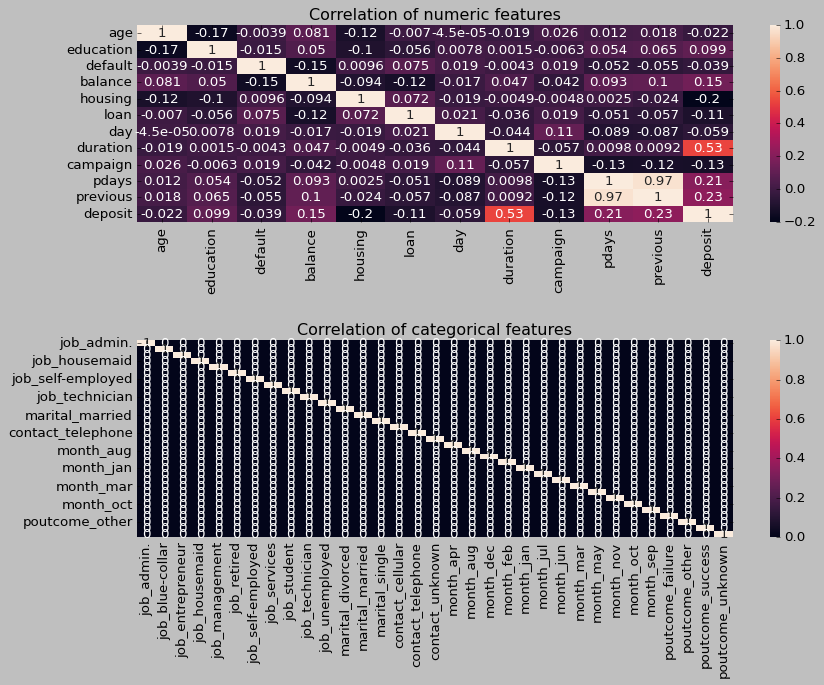

In [662]:
# Посмотрим на матрицу корреляции для числовых и бинарных признаков

# cleaned.info()
cat_cols = list()
num_cols = list()

for column in cleaned.columns:
    if cleaned[column].dtype == 'uint8':
        cat_cols.append(column)
    else:
        num_cols.append(column)
        
print(cat_cols, num_cols)

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 8))
plt.subplots_adjust(hspace = 0.6)

ax = axes[0]
sns.heatmap(cleaned[num_cols].corr(method = 'spearman'), annot = True, ax = ax)
ax.set_title('Correlation of numeric features')

ax = axes[1]
sns.heatmap(cleaned[cat_cols].corr(method = 'kendall') > 0.8, annot = True, ax = ax)
ax.set_title('Correlation of categorical features')

# Как мы можем заметить, сильно скоррелированных признаков в наших данных нет.

In [703]:
# Разделим наши данные на тренировочную и тестовыую выборку, 
# указав при этом необходимый баланс классов y переменной (параметр stratify).

X = cleaned.drop(['deposit'], axis=1)
y = cleaned['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
X_test.shape

(3335, 44)

На данный момент у нас достаточно много признаков (44): скорее всего, не все из них будут важны. 
Оставим лишь те, которые сильнее всего связаны с целевой переменной и будут вносить вклад в повышение качества модели.

С помощью SelectKBest отберем 15 признаков, наилучшим образом подходящих для использования в задаче. 

In [684]:
selector = SelectKBest(score_func = f_classif, k = 15)
selector.fit(X_train, y_train)
selected_features = selector.get_feature_names_out()

print('Наиболее значимые признаки: {}'.format(selected_features))

Наиболее значимые признаки: ['balance' 'housing' 'loan' 'duration' 'campaign' 'pdays' 'previous'
 'contact_cellular' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown']


In [704]:
# нормализуем данные с помощью minmaxsxaler

mm_scaler = preprocessing.MinMaxScaler()
X_train_scaler = mm_scaler.fit_transform(X_train[selected_features])
X_test_scaler = mm_scaler.transform(X_test[selected_features])

X_train_scaler.shape

(6770, 15)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

In [666]:
# обучим логистическую регрессию и рассчитаем метрики качества

log_reg = linear_model.LogisticRegression(random_state = 42, solver = 'sag', max_iter = 1000)
log_reg.fit(X_train_scaler, y_train)
y_train_predict = log_reg.predict(X_train_scaler)
y_test_predict = log_reg.predict(X_test_scaler)

print('Метрики для тренировочной выборки: \n {}'.format(metrics.classification_report(y_train, y_train_predict)))
print(' ')
print('Метрики для тестовой выборки: \n {}'.format(metrics.classification_report(y_test, y_test_predict)))

# Итак, значение метрики accuracy для тестовой выборки составило 0.80. 
# Попробуем использовать более сложные модели для того, чтобы улучшить показатель метрики.

Метрики для тренировочной выборки: 
               precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770

 
Метрики для тестовой выборки: 
               precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



In [667]:
# обучим решающие деревья

dt_clf = tree.DecisionTreeClassifier(random_state = 42, criterion = 'entropy')
dt_clf.fit(X_train_scaler, y_train)
y_train_clf_predict = dt_clf.predict(X_train_scaler)
y_test_clf_predict = dt_clf.predict(X_test_scaler)

print('Метрики для тренировочной выборки: \n {}'.format(metrics.classification_report(y_train, y_train_clf_predict)))
print(' ')
print('Метрики для тестовой выборки: \n {}'.format(metrics.classification_report(y_test, y_test_clf_predict)))

# Из доклада о метриках мы можем видеть переобучение модели: для тренировочной выборки наивысший показатель - 1, 
# однако на тестовой выборке показатель упал в сравнении с логистической регрессией - 0.75.

Метрики для тренировочной выборки: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770

 
Метрики для тестовой выборки: 
               precision    recall  f1-score   support

           0       0.77      0.76      0.77      1790
           1       0.73      0.74      0.74      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



Для того, чтобы избежать переобучения, подберем параметры модели, при которых будет достигнуто максимальное значение метрики accuracy, но при этом ещё не будет наблюдаться переобучения (т. е. не будет расти качество на обучающей выборке при неизменном качестве на тестовой). Используем GridSearch для подбора параметров методом перебора.

In [668]:
# подберите оптимальные параметры с помощью gridsearch

param_grid = {'min_samples_split': [2, 4, 6, 8, 10],
              'max_depth':[3,6,8]}

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        random_state = 42, 
        criterion = 'entropy'),
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)

grid_search.fit(X_train_scaler, y_train) 

print("Наилучшие значения параметров: {}".format(grid_search.best_params_))
# Наилучшие значения гиперпараметров:

print("Accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaler, y_test)))


Наилучшие значения параметров: {'max_depth': 6, 'min_samples_split': 10}
Accuracy на тестовом наборе: 0.80


In [669]:
# обучим решающие деревья c ограничением параметра максимальной глубины и количеством листьев

dt_clf = tree.DecisionTreeClassifier(random_state = 42, criterion = 'entropy', max_depth = 6, min_samples_split = 10)
dt_clf.fit(X_train_scaler, y_train)
y_train_clf_predict = dt_clf.predict(X_train_scaler)
y_test_clf_predict = dt_clf.predict(X_test_scaler)

print('Метрики для тренировочной выборки: \n {}'.format(metrics.classification_report(y_train, y_train_clf_predict)))
print(' ')
print('Метрики для тестовой выборки: \n {}'.format(metrics.classification_report(y_test, y_test_clf_predict)))

# Нам удалось избавиться от переобучение, улучшить метрику на тренировочной выборке, добиться результата в 0.80 на тестовой выборке.

Метрики для тренировочной выборки: 
               precision    recall  f1-score   support

           0       0.81      0.86      0.83      3634
           1       0.82      0.77      0.79      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.81      0.81      6770
weighted avg       0.82      0.82      0.82      6770

 
Метрики для тестовой выборки: 
               precision    recall  f1-score   support

           0       0.80      0.84      0.82      1790
           1       0.81      0.76      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335



In [670]:
# Проверим, удастся ли улучшить показатели метрики, создав более сложную модель. 
# Обучим на наших данных случайный лес

rf_clf = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
)

rf_clf.fit(X_train_scaler, y_train)
y_train_pred_rf = rf_clf.predict(X_train_scaler)
y_test_pred_rf = rf_clf.predict(X_test_scaler)

print(metrics.classification_report(y_test, y_test_pred_rf))
print(metrics.classification_report(y_train, y_train_pred_rf))

# Метрику accuracy для тестовой выборки удалось улучшить до 0.83.

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      3634
           1       0.83      0.86      0.84      3136

    accuracy                           0.85      6770
   macro avg       0.85      0.85      0.85      6770
weighted avg       0.85      0.85      0.85      6770



# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

In [671]:
# используем для классификации градиентный бустинг и сравним качество метрики со случайным лесом

gb = GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)

gb.fit(X_train_scaler, y_train)
gb_train_perdict = gb.predict(X_train_scaler)
gb_test_predict = gb.predict(X_test_scaler)

print(f'Качество предсказания для GradientBoostingClassifier на тестовой выборке \n {metrics.classification_report(y_test, gb_test_predict)}')

# Показатель метрики accuracy для тестовой выборки упал в сравнении со случайным лесом до 0.82.

Качество предсказания для GradientBoostingClassifier на тестовой выборке 
               precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



In [672]:
# Попробуем объединить используемые ранее алгоритмы (логистическую регрессию, решающие деревья и градиентный бустинг)с помощью стекинга 

estimators = [
    ('lr', linear_model.LogisticRegression(random_state = 42, solver = 'sag', max_iter = 1000)),
    ('dt', tree.DecisionTreeClassifier(random_state = 42, criterion = 'entropy', max_depth = 6, min_samples_split = 10)),
    ('gb', GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 300, min_samples_leaf = 5, max_depth = 5, random_state = 42))
]

reg = StackingClassifier(
    estimators=estimators, 
    final_estimator=linear_model.LogisticRegression(
        solver = 'sag',
        max_iter = 1000,                   
        random_state=42)
    )

reg.fit(X_train_scaler, y_train)
y_train_predict_reg = reg.predict(X_train_scaler)
y_test_predict_reg = reg.predict(X_test_scaler)

print(f'Качество предсказания для стекинга на тестовой выборке \n {metrics.classification_report(y_test, y_test_predict_reg)}')

# Используя стекинг из разных моделей, удалось добиться значения метрики 0.83 на тестовой выборке.

Качество предсказания для стекинга на тестовой выборке 
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.83      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.83      0.83      3335



Разумеется, не все признаки одинаково хорошо предсказывают результат маркетинговой кампании. 
Для того чтобы отобрать наиболее значимые для нас аспекты, на которые надо будет обратить внимание при реализации следующей акции, выберем три признака, дающих наибольший вклад.

In [673]:
selector = SelectKBest(f_classif, k=3)
selector.fit(X_train, y_train)
 
print('Наиболее важные признаки при планировании кампании: {}'.format(selector.get_feature_names_out()))

Наиболее важные признаки при планировании кампании: ['duration' 'contact_unknown' 'poutcome_success']


In [705]:
# Наилучшее значение метрики удалось добиться, использую для решения задачи алгоритм случайного леса. 
# Попробуем подобрать параметры для этого алгоритма из более широкой сетки с помощью фреймворка Optuna.

def optuna_rf(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 5, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)

  model.fit(X_train, y_train)
  score = cross_val_score(model, X_train, y_train, cv=5,  n_jobs=-1).mean()

  return score
  
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
%time study.optimize(optuna_rf, n_trials=20)


model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scaler, y_train)
y_test_pred = model.predict(X_test_scaler)
print('accuracy_score на тестовом наборе: {:.2f}. Наилучшая комбинация параметров: {}'.format(metrics.accuracy_score(y_test, y_test_pred), study.best_params))

# значение метрики на тестовой наборе 0.82.

[I 2024-04-30 18:03:56,094] A new study created in memory with name: RandomForestClassifier
[I 2024-04-30 18:04:21,695] Trial 0 finished with value: 0.8480059084194977 and parameters: {'n_estimators': 139, 'max_depth': 27, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8480059084194977.
[I 2024-04-30 18:04:30,219] Trial 1 finished with value: 0.8539143279172821 and parameters: {'n_estimators': 122, 'max_depth': 18, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8539143279172821.
[I 2024-04-30 18:04:42,674] Trial 2 finished with value: 0.8104874446085673 and parameters: {'n_estimators': 168, 'max_depth': 5, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8539143279172821.
[I 2024-04-30 18:04:53,798] Trial 3 finished with value: 0.842245199409158 and parameters: {'n_estimators': 127, 'max_depth': 10, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8539143279172821.
[I 2024-04-30 18:05:00,191] Trial 4 finished with value: 0.8271787296898079 and parameters: {'n_es

CPU times: user 36.7 s, sys: 4.23 s, total: 40.9 s
Wall time: 3min 58s
accuracy_score на тестовом наборе: 0.82. Наилучшая комбинация параметров: {'n_estimators': 116, 'max_depth': 23, 'min_samples_leaf': 2}


duration            0.386120
age                 0.067198
balance             0.061408
day                 0.054865
poutcome_success    0.040986
pdays               0.036189
housing             0.032263
dtype: float64

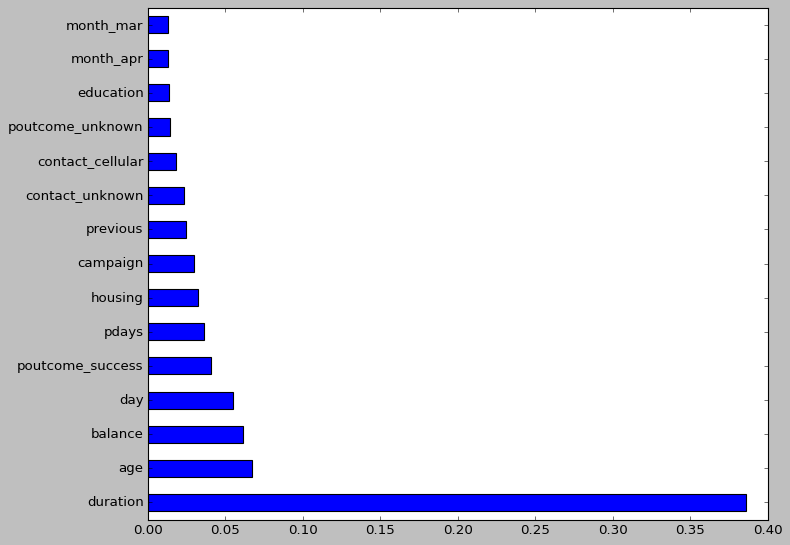

In [707]:
# Выведем важнейшие признаки для модели:
model.fit(X_train, y_train)
plt.rcParams['figure.figsize'] = (10,8)
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
feat_importances.nlargest(7)

In [708]:
# Попробуем обучим модель на 4 наиболее важных для нее признаках и посмотрим на качество метрики

def optuna_rf(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 5, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)

  model.fit(X_train[['duration', 'age', 'balance', 'day']], y_train)
  score = cross_val_score(model, X_train[['duration', 'age', 'balance', 'day']], y_train, cv=5,  n_jobs=-1).mean()

  return score
  
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
%time study.optimize(optuna_rf, n_trials=20)


model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scaler, y_train)
y_test_pred = model.predict(X_test_scaler)
print('accuracy_score на тестовом наборе: {:.2f}. Наилучшая комбинация параметров: {}'.format(metrics.accuracy_score(y_test, y_test_pred), study.best_params))

# значение метрики на тестовой наборе 0.83.

[I 2024-04-30 18:09:02,080] A new study created in memory with name: RandomForestClassifier
[I 2024-04-30 18:09:24,222] Trial 0 finished with value: 0.7740029542097489 and parameters: {'n_estimators': 200, 'max_depth': 28, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7740029542097489.
[I 2024-04-30 18:09:32,569] Trial 1 finished with value: 0.7725258493353028 and parameters: {'n_estimators': 133, 'max_depth': 13, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7740029542097489.
[I 2024-04-30 18:09:42,432] Trial 2 finished with value: 0.7723781388478583 and parameters: {'n_estimators': 142, 'max_depth': 29, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7740029542097489.
[I 2024-04-30 18:09:50,316] Trial 3 finished with value: 0.7717872968980798 and parameters: {'n_estimators': 116, 'max_depth': 17, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7740029542097489.
[I 2024-04-30 18:10:00,205] Trial 4 finished with value: 0.7717872968980798 and parameters: {'n_

CPU times: user 51.6 s, sys: 4.96 s, total: 56.6 s
Wall time: 3min 38s
accuracy_score на тестовом наборе: 0.83. Наилучшая комбинация параметров: {'n_estimators': 173, 'max_depth': 25, 'min_samples_leaf': 7}


Таким образом, нам удалось добиться показателя метрики accuracy 0.83, что показывает долю правильных ответов среди всех ответов модели. 
Использование данной модели потенциально способно сократить расходы компании на ресурсы, которые были бы затрачены на контакт с клиентами, которые вероятнее всего не откроют депозит. А так же приобрести большее количество клиентов, которые согласятся открыть депозит за счет работы сотрудников банка с клиентами, которые с большей долей вероятности готовы открыть депозит.